<a href="https://colab.research.google.com/github/anuragal/deep-learning/blob/master/S12/imagenet_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
! git clone https://github.com/anuragal/deep-learning deep_learning
! ls 'deep_learning/tiny-imagenet-200/'

fatal: destination path 'deep_learning' already exists and is not an empty directory.
test  train  val  wnids.txt  words.txt


In [2]:
# ! mv 'deep-learning' 'deep_learning'


In [6]:
! cd 'deep_learning' && git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/anuragal/deep-learning
   b215357e8..24eb818e1  master     -> origin/master
Updating b215357e8..24eb818e1
Fast-forward
 S12/datamodel.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)


## Model

In [1]:
!pip install albumentations==0.4.5

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

#Load Resnet18
model = models.resnet18()

#Finetune Final few layers to adjust for tiny imagenet input
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc.out_features = 200
model = model.to(device)

summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [

## Run the Model

In [2]:
%matplotlib inline

In [3]:
import torch.nn as nn

from deep_learning.S12.dataloader import ImageData
from deep_learning.S12.datamodel import DataModel
from deep_learning.S12.optimizer import OptimizerFactory

from torch.optim.lr_scheduler import OneCycleLR

dataset_path = 'deep_learning/tiny-imagenet-200/'
# Loading data and transforming it
img_data = ImageData()

# Choose from "albumentations" or "pytorch". Default is "pytorch"
img_data.load_TINY_IMAGENET(dataset_path, "albumentations")

criterion = nn.CrossEntropyLoss()

# optimizer can be choose from "SGD" & "Adam"
optim_sgd = OptimizerFactory("SGD")
optimizer = optim_sgd.load(params=model.parameters(), lr=0.02, momentum=0.9, weight_decay=1e-4)

dm = DataModel(img_data, criterion, optimizer, None, num_of_epochs = 30, cal_misclassified = True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
  pip install torch-lr-finder -v --global-option="amp"


CUDA Available? True
{22: 76908, 119: 76460, 58: 76982, 48: 76632, 110: 76978, 8: 76286, 191: 76981, 5: 76931, 44: 76966, 88: 76821, 9: 76767, 97: 76848, 166: 76702, 1: 76835, 74: 76976, 128: 76869, 145: 76587, 92: 76668, 183: 76842, 101: 76790, 134: 76747, 179: 76937, 47: 76854, 17: 76857, 120: 76968, 99: 76598, 25: 76964, 112: 76979, 72: 76662, 152: 76948, 3: 76585, 71: 76748, 174: 76672, 154: 76900, 196: 76917, 198: 76870, 158: 76800, 164: 76961, 75: 76962, 176: 76936, 50: 76889, 189: 76594, 33: 76763, 100: 76764, 84: 76915, 133: 76927, 7: 76910, 82: 76953, 54: 76597, 41: 76959, 140: 76828, 103: 76704, 190: 76994, 146: 76757, 34: 76965, 163: 76409, 195: 76739, 63: 76781, 16: 76710, 51: 76823, 116: 76974, 53: 76855, 194: 76874, 160: 76884, 180: 76248, 98: 76825, 32: 76960, 153: 76470, 61: 76839, 40: 76743, 188: 76984, 150: 76993, 30: 76992, 67: 76675, 70: 76847, 159: 76860, 26: 76845, 123: 76595, 23: 76886, 122: 76610, 59: 76844, 173: 76817, 104: 76971, 18: 76972, 38: 76720, 107: 763

### Find LR Max

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


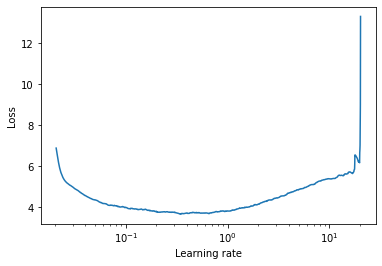

In [5]:
# lr = dm.find_lr_max(model, device)

### LR Max

In [4]:
lr = 0.3419951893353394 * 2.5
print(lr)

0.8549879733383485



## Run Model

In [5]:
dm.optimizer = optim_sgd.load(params=model.parameters(), lr=lr/10, momentum=0.9, weight_decay=0.0005)

# training the dataset and then running test
scheduler = OneCycleLR(dm.optimizer, 
                       max_lr=lr, 
                       epochs=50, 
                       steps_per_epoch = len(img_data.trainloader) + 1, 
                       div_factor=10,
                       final_div_factor=100.0,
                       pct_start=0.2
                      )
dm.schedular = scheduler
dm.run_model(model, device)

  0%|          | 0/301 [00:00<?, ?it/s]


EPOCH: 1


Loss=4.680631637573242 Batch_id=300 Accuracy=3.50: 100%|██████████| 301/301 [03:34<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 2295/33000 (6.95%)

Learning Rate: 0.104218

EPOCH: 2


Loss=4.246147155761719 Batch_id=300 Accuracy=8.80: 100%|██████████| 301/301 [03:33<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 4134/33000 (12.53%)

Learning Rate: 0.158555

EPOCH: 3


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 4445/33000 (13.47%)

Learning Rate: 0.243223

EPOCH: 4


Loss=4.085282802581787 Batch_id=300 Accuracy=14.49: 100%|██████████| 301/301 [03:33<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 4042/33000 (12.25%)

Learning Rate: 0.349981

EPOCH: 5


Loss=3.9272773265838623 Batch_id=300 Accuracy=15.67: 100%|██████████| 301/301 [03:34<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 4174/33000 (12.65%)

Learning Rate: 0.468442

EPOCH: 6


Loss=4.050654411315918 Batch_id=300 Accuracy=16.22: 100%|██████████| 301/301 [03:34<00:00,  1.40it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 5402/33000 (16.37%)

Learning Rate: 0.587078

EPOCH: 7


Loss=3.809335231781006 Batch_id=300 Accuracy=16.97: 100%|██████████| 301/301 [03:34<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 5010/33000 (15.18%)

Learning Rate: 0.694345

EPOCH: 8


Loss=3.838801860809326 Batch_id=300 Accuracy=17.25: 100%|██████████| 301/301 [03:33<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 5541/33000 (16.79%)

Learning Rate: 0.779805

EPOCH: 9


Loss=3.8271241188049316 Batch_id=300 Accuracy=17.68: 100%|██████████| 301/301 [03:34<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 4004/33000 (12.13%)

Learning Rate: 0.835142

EPOCH: 10


Loss=3.924875497817993 Batch_id=300 Accuracy=17.64: 100%|██████████| 301/301 [03:32<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 5654/33000 (17.13%)

Learning Rate: 0.854971

EPOCH: 11


Loss=3.93498158454895 Batch_id=300 Accuracy=18.57: 100%|██████████| 301/301 [03:33<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 3996/33000 (12.11%)

Learning Rate: 0.853757

EPOCH: 12


Loss=3.6179583072662354 Batch_id=300 Accuracy=18.55: 100%|██████████| 301/301 [03:33<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 5301/33000 (16.06%)

Learning Rate: 0.849919

EPOCH: 13


Loss=4.043999671936035 Batch_id=300 Accuracy=18.77: 100%|██████████| 301/301 [03:33<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 5323/33000 (16.13%)

Learning Rate: 0.843497

EPOCH: 14


Loss=3.425067663192749 Batch_id=300 Accuracy=19.25: 100%|██████████| 301/301 [03:33<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 5221/33000 (15.82%)

Learning Rate: 0.834530

EPOCH: 15


Loss=3.788902997970581 Batch_id=300 Accuracy=19.21: 100%|██████████| 301/301 [03:34<00:00,  1.40it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 5184/33000 (15.71%)

Learning Rate: 0.823072

EPOCH: 16


Loss=3.7320308685302734 Batch_id=300 Accuracy=19.72: 100%|██████████| 301/301 [03:34<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 5002/33000 (15.16%)

Learning Rate: 0.809194

EPOCH: 17


Loss=3.5492947101593018 Batch_id=300 Accuracy=19.65: 100%|██████████| 301/301 [03:33<00:00,  1.41it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 5077/33000 (15.38%)

Learning Rate: 0.792981

EPOCH: 18


Loss=3.7333779335021973 Batch_id=57 Accuracy=20.31:  19%|█▉        | 58/301 [00:42<02:52,  1.41it/s]

KeyboardInterrupt: ignored

## Plotting Test & Train Accuracy

[3.4233766233766234, 9.57922077922078, 13.864935064935064, 16.78051948051948, 18.906493506493508, 20.615584415584415, 22.22987012987013, 23.37922077922078, 24.475324675324675, 25.22987012987013, 26.47142857142857, 27.345454545454544, 27.91038961038961, 29.01818181818182, 29.45974025974026, 30.198701298701298, 30.725974025974025]
[5.206060606060606, 10.766666666666667, 15.712121212121213, 15.675757575757576, 16.76060606060606, 17.636363636363637, 20.042424242424243, 19.784848484848485, 19.681818181818183, 22.20909090909091, 23.26060606060606, 18.73030303030303, 20.26969696969697, 24.578787878787878, 20.493939393939392, 24.672727272727272, 26.13030303030303]


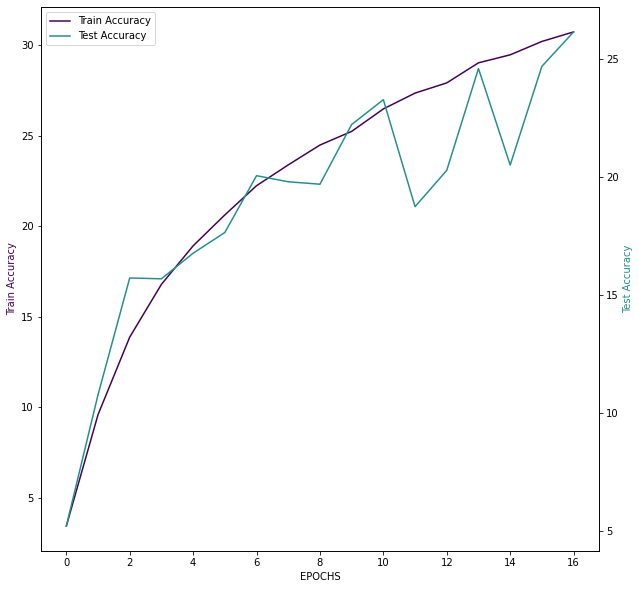

In [8]:
dm.plot_test_train_accuracy()

## Plotting Validation Accuracy

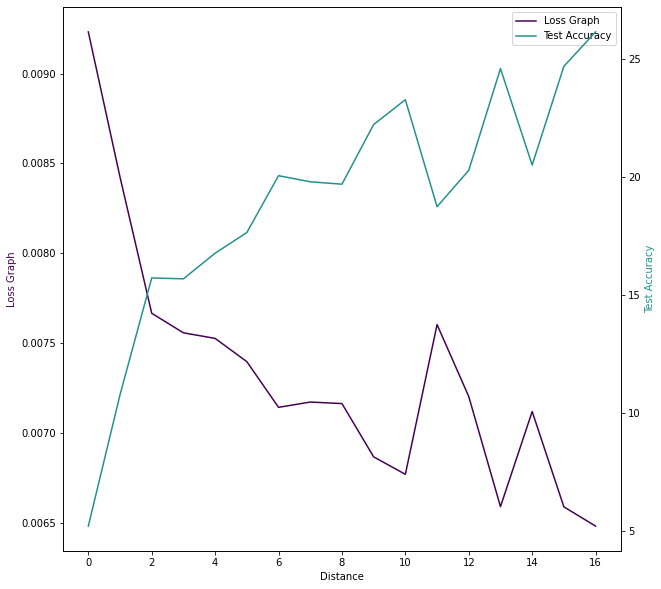

In [10]:
dm.plot_loss_accuracy()

In [12]:
dm.plot_GRADcam(["layer1","layer2","layer3"])

RuntimeError: ignored